In [1]:
import torch
import numpy as np
from tqdm import tqdm
from analytical_expressions import local_energy
from torch.autograd.functional import jacobian
from torch.func import jacrev
import matplotlib.pyplot as plt
from torch.func import vmap

In [359]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def psi(X):
    x = X[:3]
    y = X[3:6]
    alpha_1, alpha_2, alpha_3, alpha_4 = X[6:]
    r1 = torch.norm(x)
    r2 = torch.norm(y)
    r12 = torch.norm(x - y)

    term1 = torch.exp(-2 * (r1 + r2))
    term2 = 1 + 0.5 * r12 * torch.exp(-alpha_1 * r12)
    term3 = 1 + alpha_2 * (r1 + r2) * r12 + alpha_3 * (r1 - r2)**2 - alpha_4 * r12

    return term1 * term2 * term3

In [4]:
psi_vec = vmap(psi)

In [67]:
torch.rand(3)

tensor([0.0019, 0.3977, 0.3567])

In [298]:
def metropolis(N: int, n_runs: int, alphas: torch.tensor):  
    """
    Vectorized metropolis loop
    Over N steps, for n_runs. 
    Alphas passes in must be of same dim as n_runs
    """  
    assert alphas.shape[0] == n_runs        
    L = 1
    r1 = (torch.rand(n_runs, 3) * 2 * L - L)
    r2 = (torch.rand(n_runs, 3) * 2 * L - L)
    max_steps = 500
    sampled_Xs = []
    rejection_ratio = 0

    for i in tqdm(range(N)):
        chose = torch.rand(n_runs).reshape(n_runs, 1)
        dummy = torch.rand(n_runs)

        perturbed_r1 = r1 + 0.5 * (torch.rand(n_runs, 3) * 2 * L - L)
        perturbed_r2 = r2 + 0.5 * (torch.rand(n_runs, 3) * 2 * L - L)

        r1_trial = torch.where(chose < 0.5, perturbed_r1, r1)
        r2_trial = torch.where(chose >= 0.5, perturbed_r2, r2)
        psi_val = psi_vec(torch.cat((r1, r2, alphas), axis=1))
        psi_trial_val = psi_vec(torch.cat((r1_trial, r2_trial, alphas), axis=1))      
        psi_ratio = psi_trial_val / psi_val

        density_comp = psi_trial_val >= psi_val
        dummy_comp = dummy < psi_ratio

        condition = density_comp + dummy_comp

        rejection_ratio += torch.where(condition, 1./N, 0.0)

        condition = condition.reshape(condition.shape[0], 1)

        # Careful with overwriting
        r1 = torch.where(condition, r1_trial, r1)
        r2 = torch.where(condition, r2_trial, r2)
                
        if i > max_steps:
            sampled_Xs.append(torch.cat((r1, r2, alphas), axis=1))

    print(f"Rejection ratio is {torch.mean(rejection_ratio)}")

    return torch.stack(sampled_Xs)

In [255]:
local_e_vec = vmap(local_energy)
local_e_vec_vec = vmap(local_e_vec)

def get_local_energies(X):
    reshaped_X = X.reshape(
        X.shape[1], X.shape[0], X.shape[2])
    return local_e_vec_vec(reshaped_X)

def get_mean_energies(E):
    return torch.mean(torch.mean(E, dim=1))

In [256]:
def dE_dalpha(input):
    return jacrev(local_energy)(input)

dE_dalpha_vec = vmap(dE_dalpha)
dE_dalpha_vec_vec = vmap(dE_dalpha_vec)

def get_dE_dX(X):
    reshaped_X = X.reshape(
        X.shape[1], X.shape[0], X.shape[2])
    return dE_dalpha_vec_vec(X)

In [215]:
from gradient_expressions import get_psi_alpha

def get_gradients_from_expression(X_, E_):
    psi_alpha = vmap(get_psi_alpha)(X_)

    part_1 = psi_alpha - torch.mean(psi_alpha, axis=0)
    part_2 = E_ - torch.mean(E_)
    return torch.mean(part_1.T * part_2, axis=1)

dE_dalpha = vmap(get_gradients_from_expression)

In [216]:
alpha_1 = torch.tensor(1.013, dtype=torch.float64, requires_grad=True) # 1.013
alpha_2 = torch.tensor(0.2119, dtype=torch.float64, requires_grad=True)
alpha_3 = torch.tensor(0.1406, dtype=torch.float64, requires_grad=True)
alpha_4 = torch.tensor(0.003, dtype=torch.float64, requires_grad=True)

In [217]:
device = torch.device("cuda")
cpu = torch.device("cpu")

In [265]:
def running_average(tensor, window_size=None):
    cumsum = torch.cumsum(tensor, dim=0)
    if window_size is None:
        # For the full running average (over all elements)
        return cumsum / torch.arange(1, len(tensor) + 1, device=tensor.device, dtype=torch.float32)
    else:
        # For a moving average with a fixed window size
        window = torch.ones(window_size, device=tensor.device)
        conv = torch.conv1d(tensor.unsqueeze(0).unsqueeze(0), window.unsqueeze(0).unsqueeze(0), padding=window_size//2)
        return conv.squeeze(0).squeeze(0)

## Start of simulation

In [218]:
alpha_1 = torch.tensor(1.013, dtype=torch.float64) # 1.013
alpha_2 = torch.tensor(0.2119, dtype=torch.float64)
alpha_3 = torch.tensor(0.1406, dtype=torch.float64)
alpha_4 = torch.tensor(0.003, dtype=torch.float64)

In [285]:
# 0.25793396445032235, -0.7848700775648312, 1.1531981456196378, -0.04541513347032762
alpha_1 = torch.tensor(0.257933, dtype=torch.float64) # 1.013
alpha_2 = torch.sigmoid(torch.tensor(-0.78487, dtype=torch.float64))
alpha_3 = torch.tensor(1.1531, dtype=torch.float64)
alpha_4 = torch.sigmoid(torch.tensor(-0.0454, dtype=torch.float64))

In [294]:
alpha_1

tensor(0.2579, dtype=torch.float64)

In [360]:
n_steps = 100
mc_steps = 10000
alphas = torch.tensor([alpha_1, alpha_2, alpha_3, alpha_4]).unsqueeze(0).repeat(n_steps, 1)
sampled_Xs = metropolis(mc_steps, n_steps, alphas=alphas)

100%|██████████| 10000/10000 [00:08<00:00, 1142.00it/s]

Rejection ratio is 0.7994472980499268


In [361]:
E = get_local_energies(sampled_Xs.to(device))
mean_E = get_mean_energies(E.to(cpu))
print(f"Mean energy is {torch.mean(torch.mean(E, axis=1))}")

Mean energy is -3.067813110225438


In [259]:
E = E.to(cpu)

In [325]:
reshaped_X = sampled_Xs.reshape(
        sampled_Xs.shape[1], sampled_Xs.shape[0], sampled_Xs.shape[2])

In [326]:
reshaped_X.shape

torch.Size([100, 9499, 10])

In [365]:
def get_energy(X):
    X.requires_grad_(True)
    psi_val = psi(X)

    # First gradient
    grad = torch.autograd.grad(psi_val, X, create_graph=True)[0]

    # Laplacian = sum of second derivatives
    laplacian = 0.0
    for i in range(X.shape[0]):
        second_deriv = torch.autograd.grad(grad[i], X, create_graph=True)[0][i]
        laplacian += second_deriv

    ke = -0.5 * laplacian / psi_val

    r1 = X[:3]
    r2 = X[3:6]
    potential = -2 / torch.norm(r1) - 2 / torch.norm(r2) + 1 / torch.norm(r1 - r2)

    return ke + potential

In [338]:
reshaped_X.shape

torch.Size([100, 9499, 10])

In [366]:
# Verifying local energy using Hessian
E_es = []

for i in tqdm(reshaped_X[0]):
    E_es.append(get_energy(i))

100%|██████████| 9499/9499 [02:06<00:00, 75.25it/s]


In [370]:
E_es

[tensor(-3.8113, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(-4.3623, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(-5.0609, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(-4.9455, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(-14.5549, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(-2.5431, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(-4.1197, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(-4.8440, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(-5.4451, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(-4.6506, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(-1.8323, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(-5.3013, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(-14.1277, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(-4.1985, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(-5.0003, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(-4.8785, dtype=torch.float64, grad_fn=<AddBac

In [369]:
torch.mean(torch.stack(E_es).detach())

tensor(-5.3259, dtype=torch.float64)

In [356]:
torch.mean(E[0])

tensor(-3.1468, device='cuda:0', dtype=torch.float64)

In [336]:
E/10000

tensor(-3.1404, dtype=torch.float64)

In [272]:
cumulative_average_energy = running_average(torch.mean(E, axis=0))

In [273]:
cumulative_average_energy

tensor([-2.6816, -2.8029, -2.7848,  ..., -2.8941, -2.8941, -2.8940],
       dtype=torch.float64)

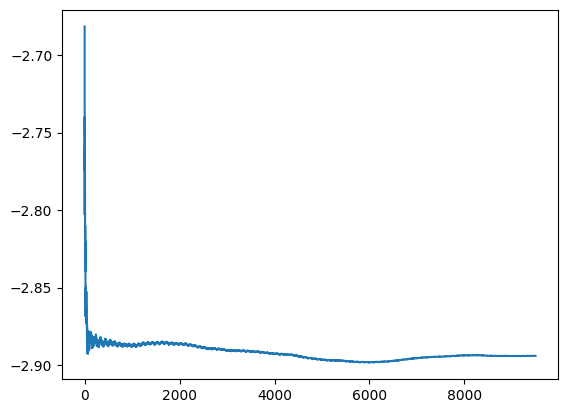

In [274]:
plt.plot(cumulative_average_energy)

In [243]:
E = E.to(cpu)

In [244]:
# Variance in random walkers mean energy
torch.mean((torch.mean(E.to(cpu), axis=1) - mean_E) ** 2)

tensor(0.0209, dtype=torch.float64)

In [245]:
mean_E_trial = torch.mean(E[0])

In [246]:
var_E_trial = torch.mean((E[0] - mean_E_trial) ** 2)

In [247]:
var_E_trial

tensor(2.3716, dtype=torch.float64)

In [199]:
gradients = get_dE_dX(sampled_Xs)

In [200]:
gradients.shape

torch.Size([197999, 10, 10])

In [ ]:
gradients[:,,0]

IndexError: too many indices for tensor of dimension 2

In [ ]:
gradients = dE_dalpha(reshaped_X, E)

In [204]:
gradients

tensor([[ 0.0200,  0.9286, -0.3509,  0.0442],
        [ 0.0192,  0.9276, -0.3715,  0.0441],
        [ 0.0197,  0.9357, -0.3774,  0.0445],
        [ 0.0202,  0.9328, -0.4052,  0.0444],
        [ 0.0185,  0.9524, -0.3745,  0.0402],
        [ 0.0193,  0.9448, -0.3588,  0.0458],
        [ 0.0196,  0.9282, -0.3814,  0.0436],
        [ 0.0191,  0.9400, -0.3920,  0.0426],
        [ 0.0193,  0.9328, -0.3661,  0.0448],
        [ 0.0194,  0.9308, -0.3764,  0.0435]], dtype=torch.float64)

In [202]:
reshaped_X = sampled_Xs.reshape(
        sampled_Xs.shape[1], sampled_Xs.shape[0], sampled_Xs.shape[2])

Energy value should be −2.901188

The actual value is −2.9037243770

## Optimization loop

In [43]:
import math

In [44]:
E_true = -2.9037243770

In [45]:
alpha_1 = torch.tensor(0.013, dtype=torch.float64, requires_grad=True) # 1.013
alpha_2 = torch.tensor(0.6419, dtype=torch.float64, requires_grad=True) # 0.2119
alpha_3 = torch.tensor(0.1406, dtype=torch.float64, requires_grad=True) # 0.1406
alpha_4 = torch.tensor(0.103, dtype=torch.float64, requires_grad=True) # 0.003

In [46]:
device = torch.device("cuda")
cpu = torch.device("cpu")

In [49]:
# Naive approach - define loss as true energy - found energy

epochs = 2000
alphas = [alpha_1, alpha_2, alpha_3, alpha_4]
losses = []
n_walkers = 200
met_steps = 5000
optimizer = torch.optim.Adam(alphas, lr=0.001)

for i in range(epochs):

    alphas_metropolis = torch.tensor(alphas).unsqueeze(0).repeat(n_walkers, 1)
    sampled_Xs = metropolis(met_steps, n_walkers, alphas=alphas_metropolis)

    with torch.no_grad():
        E = get_local_energies(sampled_Xs)
        mean_E = get_mean_energies(E)
        loss = torch.abs(E_true - mean_E)

        print(f"Mean energy is {mean_E}")
        print(f"Loss is {loss}")
        losses.append(loss.item())

        reshaped_X = sampled_Xs.reshape(
            sampled_Xs.shape[1], sampled_Xs.shape[0], sampled_Xs.shape[2])
        gradients = dE_dalpha(reshaped_X, E).to(cpu)

        # Now, assume you already have gradients computed externally:
        # Example: for step t, these are your gradients (replace with actual values)
        gradients = torch.mean(gradients, axis=0)
        external_grads = gradients.detach()

        # Step 3: Assign gradients manually
        for p, g in zip(alphas, external_grads):
            p.grad = g  # assign your externally computed gradient

    # Step 4: Optimizer step
    optimizer.step()
    optimizer.zero_grad()

    torch.cuda.empty_cache()
    del sampled_Xs
    del reshaped_X
    del E




100%|██████████| 5000/5000 [00:04<00:00, 1031.75it/s]


Mean energy is -2.533333871679624
Loss is 0.3703905053203762


100%|██████████| 5000/5000 [00:04<00:00, 1051.96it/s]


Mean energy is -2.5332306674936587
Loss is 0.3704937095063414


 17%|█▋        | 871/5000 [00:00<00:04, 989.91it/s] 


KeyboardInterrupt: 

In [26]:
print(gradients)

tensor([-0.0752,  3.5492, -0.0362, -0.6221], dtype=torch.float64,
       grad_fn=<MeanBackward1>)


In [27]:
print(alphas)

[tensor(0.5331, dtype=torch.float64, requires_grad=True), tensor(-0.0537, dtype=torch.float64, requires_grad=True), tensor(0.7332, dtype=torch.float64, requires_grad=True), tensor(-0.0505, dtype=torch.float64, requires_grad=True)]


In [137]:
alpha_1 = torch.tensor(2.013, dtype=torch.float64, requires_grad=True) # 1.013
alpha_2 = torch.tensor(0.6419, dtype=torch.float64, requires_grad=True) # 0.2119
alpha_3 = torch.tensor(2.1406, dtype=torch.float64, requires_grad=True) # 0.1406
alpha_4 = torch.tensor(3.003, dtype=torch.float64, requires_grad=True) # 0.003

In [113]:
alpha_1

tensor(2.0130, dtype=torch.float64, requires_grad=True)

In [106]:
external_grads

tensor([-0.0080,  0.0429,  0.0155, -0.0305], dtype=torch.float64)

## Gradient values

In [34]:
def dE_dalpha(input):
    return jacrev(local_energy)(input)

t = dE_dalpha_vec(torch.stack(inputs_arr[0]))

In [72]:
dE_dalpha_mean = torch.mean(t, axis=0)

In [36]:
psi_vmap = vmap(psi)

In [38]:
psi_values = psi_vmap(torch.stack(inputs_arr[0]))

In [61]:
mean_energy = sum(energies[0])/(len(energies[0]))

In [63]:
El_Etheta = energies[0] - mean_energy

In [65]:
mean_psi = torch.mean(psi_values)

In [73]:
dE_dalpha_mean.shape

torch.Size([10])

In [86]:
t[0].shape

torch.Size([10])

In [89]:
psi_values.shape

torch.Size([9500])

In [92]:
psi_dalph = torch.stack([psi_values[i] * t[i] for i in range(len(t))])

In [97]:
psi_dalph.shape

torch.Size([9500, 10])

In [98]:
dE_dalpha_mean.shape

torch.Size([10])

In [95]:
mean_psi

tensor(0.0207, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [77]:
t.shape

torch.Size([9500, 10])

In [111]:
a = psi_values.unsqueeze(1).repeat(1, 10) * t

In [110]:
b = (mean_psi * dE_dalpha_mean).unsqueeze(0).repeat(9500, 1)

In [119]:
c = (energies[0] - mean_energy).unsqueeze(1).repeat(1, 10)

In [115]:
mean_energy.shape

torch.Size([])

In [120]:
gradients = (a - b) * (c)

In [124]:
torch.mean(gradients, axis=0)

tensor([ 0.0652,  0.4838,  0.4329,  0.0146,  0.1017,  0.0883,  0.0167, -0.0222,
        -0.0307,  0.0271], dtype=torch.float64, grad_fn=<MeanBackward1>)

In [52]:
energies[0][1]

tensor(-1.6312, dtype=torch.float64, grad_fn=<SelectBackward0>)

In [53]:
E_fixed = [energies[0][i] / psi_values[i] for i in range(len(inputs_arr[0]))]

In [55]:
torch.mean(torch.stack(E_fixed))

tensor(-2546.7772, dtype=torch.float64, grad_fn=<MeanBackward0>)